<a href="https://colab.research.google.com/github/adriasell/Multi-omics-integration-Tutorial/blob/main/multiomics_integration_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-omics integration tutorial**

**Adrià Setó Llorens**, Predoctoral Researcher at the Barcelona Institute for Global Health (ISGlobal).

**Augusto Anguita-Ruiz**, Junior Leader Researcher at the Barcelona Institute for Global Health (ISGlobal).

The multi-omics approach aims to integrate diverse layers of biological information—such as genomics, transcriptomics, proteomics, metabolomics, and epigenomics—to achieve a more comprehensive understanding of biological systems and disease mechanisms. Each omic layer captures a distinct yet interconnected level of cellular regulation, and their integration enables the identification of molecular interactions that cannot be detected through single-omic analyses alone. The main advantage of multi-omics integration over traditional single-omic studies lies in its ability to uncover cross-level biological relationships and multi-factorial drivers of phenotypes, improving prediction accuracy and mechanistic insight. This systems-level perspective supports the discovery of key biomarkers, regulatory networks, and potential therapeutic targets.

There are many multi-omics integration algorithms, each suited for different analytical goals, and they can be classified according to whether they are supervised or unsupervised and whether they perform variable selection—in this session, we will focus on the **RGCCA** (Regularized Generalized Canonical Correlation Analysis) approach.

The objective of this session to offer an introduction to a multi-omics integration analysis using **RGCCA**. We will:
* Load the data
* Preprocess the data
* Perform multi-omics integration
* Understand the results of multi-omics integration
* Evaluate the algorithm’s performance


We will integrate multi-omics data — including proteomics, gene expression, and DNA methylation — using Regularized Generalized Canonical Correlation Analysis (RGCCA). The outcome variable will be standardized body mass index (zBMI) at 9 years old. The objective of this analysis is to identify multi-omic signatures predictive of BMI in later childhood while gaining a hands-on understanding of the application of RGCCA to multi-omics data integration.



# **Reminder: Introduction to NoteBook**
This notebook will guide you step by step, from loading a dataset to analyzing it.

Getting Started:
* Open multiomics_integration_tutorial.ipynb and click “Open in Colab” (sign in with your Google account if needed).
* Select “Open in draft mode” at the top left so you can run the code safely.
* If you see "Warning: This notebook was not created by Google.", don’t worry—just click Run anyway.

How to Use the Notebook:
* The notebook mixes text explanations and code cells for hands-on learning.
* Always run cells in order to avoid errors.
* Click the play button next to a cell, or press Ctrl+Enter (Cmd+Enter on Mac).
* Lines starting with # are comments for guidance, they won’t affect the code.

## **1. Installation of the R Environment and Libraries for multi-omics integration** <a name="install-libraries"></a>

Below, we install/load the libraries necessary for this session. In the context of multi-omics integration, R and Bioconductor libraries offer us a much more convenient way to process, manipulate, and analyze the data.

Bioconductor is an open-source software platform built on R for analyzing and interpreting genomic and other omics data.
Its packages provide specialized tools for tasks such as data processing, normalization, statistical analysis, and biological data visualization.
  
The installation of R in our Google Colab environment will be carried out in the following code block. It should be remembered that all library installations we perform in the Google Colab environment will only remain active for a few hours, after which the installed libraries are removed. Therefore, it will be necessary for you to re-run the library installation code in this section whenever you need to run the notebook again after this time.

**Note:** We recommend installing the libraries and downloading the data **1h** before the start of the session❗❗❗

* **Install/load libraries for the session**

In [34]:
# List of required packages (1h)

# Define CRAN packages
cran_packages <- c(
  "BiocManager", "doParallel", "data.table", "readxl", "networkD3", "knitr", "ggforce", "remotes",
  "dplyr", "ggplot2", "corrplot", "fastDummies", "polycor", "tidyverse", "gridExtra",
  "parallel", "writexl", "RCurl", "doSNOW", "DescTools", "limma", "webshot", "htmlwidgets"
)

# Define Bioconductor packages
bioc_packages <- c("lumi", "minfi", "Biobase", "clusterProfiler", "org.Hs.eg.db", "IlluminaHumanMethylation450kanno.ilmn12.hg19", "enrichplot")

# --- Helper function to install missing packages ---
install_if_missing <- function(pkgs, bioconductor = FALSE) {
  missing_pkgs <- pkgs[!pkgs %in% installed.packages()[, "Package"]]
  if (length(missing_pkgs) > 0) {
    message("\nInstalling missing ", if (bioconductor) "Bioconductor" else "CRAN", " packages...")
    if (bioconductor) {
      BiocManager::install(missing_pkgs, ask = FALSE, quiet = TRUE)
    } else {
      install.packages(missing_pkgs, dependencies = TRUE, quiet = TRUE)
    }
  }
}

# --- Install packages ---
install_if_missing(cran_packages)
install_if_missing(bioc_packages, bioconductor = TRUE)

# --- Load packages quietly ---
load_quietly <- function(pkg) {
  suppressWarnings(suppressMessages(library(pkg, character.only = TRUE)))
}

invisible(lapply(c(cran_packages, bioc_packages), load_quietly))

In [35]:
#install modified RGCCA
url <- "https://github.com/adriasell/Multi-omics-integration-Tutorial/raw/main/RGCCA-main.zip"
dest <- "RGCCA-main.zip"
download.file(url, destfile = dest, mode = "wb")
unzip("RGCCA-main.zip")
remotes::install_local("RGCCA-main")
library("RGCCA")

Skipping install of 'RGCCA' from a local remote, the SHA1 (3.0.3) has not changed since last install.
  Use `force = TRUE` to force installation



## **2. Load the Data** <a name="load-data"></a>

Below are the **lines of code** necessary to **load** the dataset into the R environment. For this practical session, we will use data from the HELIX (Human Early-Life Exposome) exposome study. The HELIX study is a collaborative project among six population-based birth cohort longitudinal studies from six European countries (France, Greece, Lithuania, Norway, Spain, and the United Kingdom).

<img src="https://github.com/AugustoAnguita/ATHLETE.ExposomeAnalysis.Tutorial_draft/blob/main/figures/HELIX.png?raw=1" alt="HELIX logo" width="500"/>


**Note:** The data provided in this introductory course were semi-simulated from the real data of the HELIX sub-cohort. For more details on the HELIX project and the origin of the data collected we recommend consulting the following publication: https://bmjopen.bmj.com/content/8/9/e021311 and website: https://www.projecthelix.eu/es.

This is the dataset we will use:

- **Exposome data (n=1301)**: [Rdata file](https://github.com/isglobal-brge/brge_data_large/blob/master/data/ExposomeDataChallenge2021/exposome_NA.RData) containing three objects:
     - 1 object for exposures: `exposome`
     - 1 object for covariates: `covariates`
     - 1 object for outcomes: `phenotype`

The three tables can be linked using **ID** variable. See the [codebook](https://github.com/isglobal-brge/brge_data_large/blob/master/data/ExposomeDataChallenge2021/codebook.xlsx) for variable description (variable name, domain, type of variable, transformation, ...)


- **omic data**: Exposome and omic data can be linked using **ID** variable.
     - [Proteome](https://github.com/isglobal-brge/brge_data_large/blob/master/data/ExposomeDataChallenge2021/proteome.Rdata): ExpressionSet called `proteome` of **1170 individuals** and **39 proteins** (log-transformed) that are annotated in the `ExpressionSet` object (use `fData(proteome)` after loading `Biobase` Bioconductor package).
     - [Gene expression](https://figshare.com/s/571c8cff7acf5167f343): ExpressionSet called `genexpr`  (see [here](https://isglobal-brge.github.io/Master_Bioinformatics/bioconductor.html#expressionset) what an ExpressionSet is) of **1007 individuals** and **28,738 transcripts** with annotated gene symbols.
     - [Methylation](https://figshare.com/s/46e6a1d66ff135bb15c8): GenomicRatioSet called `methy` (see [here](https://www.rdocumentation.org/packages/minfi/versions/1.18.4/topics/GenomicRatioSet-class) what a GenomicRatioSet is) of **918 individuals** and **386,518 CpGs**

The variables that are available in the metadata are:

> 1. **ID**: identification number
> 2. **e3_sex**: gender (male, female)
> 3. **age_sample_years**: age (in years)
> 4. **h_ethnicity_cauc**: caucasic? (yes, no)
> 5. **ethn_PC1**: first PCA to address population stratification
> 6. **ethn_PC2**: second PCA to address population stratification
> 7. **Cell-type estimates** (only for methylation): NK_6, Bcell_6, CD4T_6, CD8T_6, Gran_6, Mono_6




**1.** We load the data required for the session.

In [36]:
#Estimated time 3min
# We load an RData file (this file contains datasets + the codebook)
load(url("https://github.com/isglobal-brge/brge_data_large/raw/master/data/ExposomeDataChallenge2021/exposome_NA.RData"))

# Load biological omic layers data
# 1. Proteome (ExpressionSet)
load(url("https://github.com/isglobal-brge/brge_data_large/raw/master/data/ExposomeDataChallenge2021/proteome.Rdata"))

# 2. Gene expression (ExpressionSet)
url1 <- "https://figshare.com/ndownloader/files/26540969?private_link=571c8cff7acf5167f343"
f1 <- CFILE("gene_expression.rda", mode = "wb")
curlPerform(url = url1, writedata = f1@ref, followlocation = TRUE)
close(f1)
load("gene_expression.rda")

# 3. Methylation (GenomicRatioSet)
url2 <- "https://figshare.com/ndownloader/files/26540753?private_link=46e6a1d66ff135bb15c8"
f2 <- CFILE("methylation.rda", mode = "wb")
curlPerform(url = url2, writedata = f2@ref, followlocation = TRUE)
close(f2)
load("methylation.rda")

OK 
 0

An object of class "CFILE"
Slot "ref":
<pointer: (nil)>


OK 
 0

An object of class "CFILE"
Slot "ref":
<pointer: (nil)>


**2.** We check the data structure and dimension of dataframes



In [37]:
glimpse(covariatesNA)

Rows: 1,301
Columns: 14
$ ID                <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…
$ h_cohort          <fct> 4, 4, 4, 2, 3, 1, 2, 1, 2, 1, 1, 3, 2, 2, 4, 4, 4, 4…
$ e3_sex_None       <fct> male, male, male, female, male, female, male, female…
$ e3_yearbir_None   <fct> 2008, 2007, 2008, 2005, 2005, 2007, 2003, 2008, 2004…
$ h_mbmi_None       <dbl> 25.51020, 26.49151, 30.11621, 21.04805, 22.15102, 24…
$ hs_wgtgain_None   <dbl> 17, 18, NA, 21, 20, 30, 20, NA, 12, NA, 10, 18, 5, N…
$ e3_gac_None       <dbl> 41.00000, 41.00000, 39.00000, 39.28571, 43.00000, 38…
$ h_age_None        <dbl> 28.00000, 22.84155, 34.23242, 32.72553, 20.86516, 27…
$ h_edumc_None      <fct> 2, 3, 3, 1, 1, 3, 1, 2, 2, 1, NA, 3, 3, 2, 2, 3, 3, …
$ h_native_None     <fct> 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2…
$ h_parity_None     <fct> 0, 1, 1, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1…
$ hs_child_age_None <dbl> 6.165640, 6.992471, 6.110883, 10.138261, 9.451175, 6…
$ hs_c_height_No

In [38]:
glimpse(phenotypeNA)

Rows: 1,301
Columns: 7
$ ID               <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ e3_bw            <int> 4100, 4158, 4110, 3270, 3950, 2900, 3350, 3580, 3000,…
$ hs_asthma        <dbl> 0, 0, NA, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0…
$ hs_zbmi_who      <dbl> 0.30, 0.41, 3.33, -0.76, 0.98, -0.08, 0.04, -0.10, -1…
$ hs_correct_raven <int> 18, 25, 13, 28, 19, 19, 34, 16, 35, 32, 18, 24, 30, 3…
$ hs_Gen_Tot       <dbl> 84.0000, 39.0000, 40.0000, 54.5000, 18.0000, 4.0000, …
$ hs_bmi_c_cat     <fct> 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 4, 4, 2, 2, 4, 3, 2, 2,…


In [39]:
glimpse(proteome)

Formal class 'ExpressionSet' [package "Biobase"] with 7 slots
  ..@ experimentData   :Formal class 'MIAME' [package "Biobase"] with 13 slots
  ..@ assayData        :<environment: 0x595cac88a780> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  ..@ featureData      :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  ..@ annotation       : chr(0) 
  ..@ protocolData     :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  ..@ .__classVersion__:Formal class 'Versions' [package "Biobase"] with 1 slot


In [40]:
glimpse(methy)

Formal class 'GenomicRatioSet' [package "minfi"] with 8 slots
  ..@ preprocessMethod: Named chr [1:2] "Noob, dyeCorr=TRUE" "Funnorm, nPCs=2"
  .. ..- attr(*, "names")= chr [1:2] "mu.norm" "mu.norm"
  ..@ annotation      : Named chr [1:2] "IlluminaHumanMethylation450k" "ilmn12.hg19"
  .. ..- attr(*, "names")= chr [1:2] "array" "annotation"
  ..@ rowRanges       :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  ..@ colData         :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ assays          :Reference class 'ShallowSimpleListAssays' [package "SummarizedExperiment"] with 1 field
  .. ..and 14 methods.
  ..@ NAMES           : NULL
  ..@ elementMetadata :Formal class 'DataFrame' [package "S4Vectors"] with 3 slots
  ..@ metadata        : list()


In [41]:
glimpse(genexpr)

Formal class 'ExpressionSet' [package "Biobase"] with 7 slots
  ..@ experimentData   :Formal class 'MIAME' [package "Biobase"] with 13 slots
  ..@ assayData        :<environment: 0x595ca413e1a8> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  ..@ featureData      :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  ..@ annotation       : chr(0) 
  ..@ protocolData     :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  ..@ .__classVersion__:Formal class 'Versions' [package "Biobase"] with 1 slot


An ExpressionSet is a Bioconductor data structure that stores expression: data along with sample and feature metadata, while a GenomicRatioSet is a similar structure designed to store DNA methylation data, including methylation ratios and associated genomic annotations.

## **3. Data preprocessing** <a name="data-preprocessing"></a>




First, we have to prepare the data to do the subsequent analysis. Next, we will winsorize the omics data to account for outliers. Winsorization reduces the impact of extreme values by capping them at specified percentiles (1% and 99%). Finally, we will denoise each omic layer by adjusting for key covariates such as  sex, age, and cohort using linear models. This step removes unwanted variation associated with these covariates while preserving the true biological signal in the data.

  **0. Data preparation**

  To simplify the analysis, we will use a subset of biomarkers that have been associated with the outcome [(Stratakis et al. 2025)](https://www.nature.com/articles/s41467-025-56013-7).

In [42]:
# Download the file
url <- "https://github.com/adriasell/Multi-omics-integration-Tutorial/raw/main/data/biomarkers.xlsx"
download.file(url, destfile = "biomarkers.xlsx", mode = "wb")

sheets <- excel_sheets("biomarkers.xlsx")
biomarkers_data <- lapply(sheets, read_excel, path = "biomarkers.xlsx")
names(biomarkers_data) <- sheets

#Select those biomarkers
methy <- methy[rownames(methy) %in% biomarkers_data$TS2A$`Table S2A: List of CpG sites included in the present study`, ]
genexpr <- genexpr[rownames(genexpr) %in% biomarkers_data$TS2C$`Table S2C: List of transcript clusters included in the present study`, ]

New names:
• `` -> `...2`
New names:
• `` -> `...2`
New names:
• `` -> `...2`
• `` -> `...3`
New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`


We will only use participants for whom all data are available.

In [43]:
#Select common ids btw dfs
phenotypeNA$ID <- as.character(phenotypeNA$ID)
covariatesNA$ID <- as.character(covariatesNA$ID)
common_ids <- Reduce(intersect, list(pData(proteome)$ID, pData(methy)$ID, pData(genexpr)$ID, covariatesNA[complete.cases(covariatesNA),]$ID))

proteome <- proteome[, match(common_ids, pData(proteome)$ID)]
methy <- methy[, match(common_ids, pData(methy)$ID)]
genexpr <- genexpr[, match(common_ids, pData(genexpr)$ID)]
phenotypeNA <- phenotypeNA[match(common_ids, phenotypeNA$ID), ]
covariatesNA <- covariatesNA[match(common_ids, covariatesNA$ID), ]

We have a final population (N) of:

In [44]:
ncol(proteome)

Samples 
    736

In [45]:
cat("We will study a dataset combining DNA methylation data with",
    nrow(methy), "CpG sites,",
    "gene expression data with", nrow(genexpr), "transcripts, and",
    "proteomics data with", nrow(proteome), "proteins.\n")

We will study a dataset combining DNA methylation data with 793 CpG sites, gene expression data with 219 transcripts, and proteomics data with 36 proteins.


Let's do a descriptive study of the outcome and covariates.

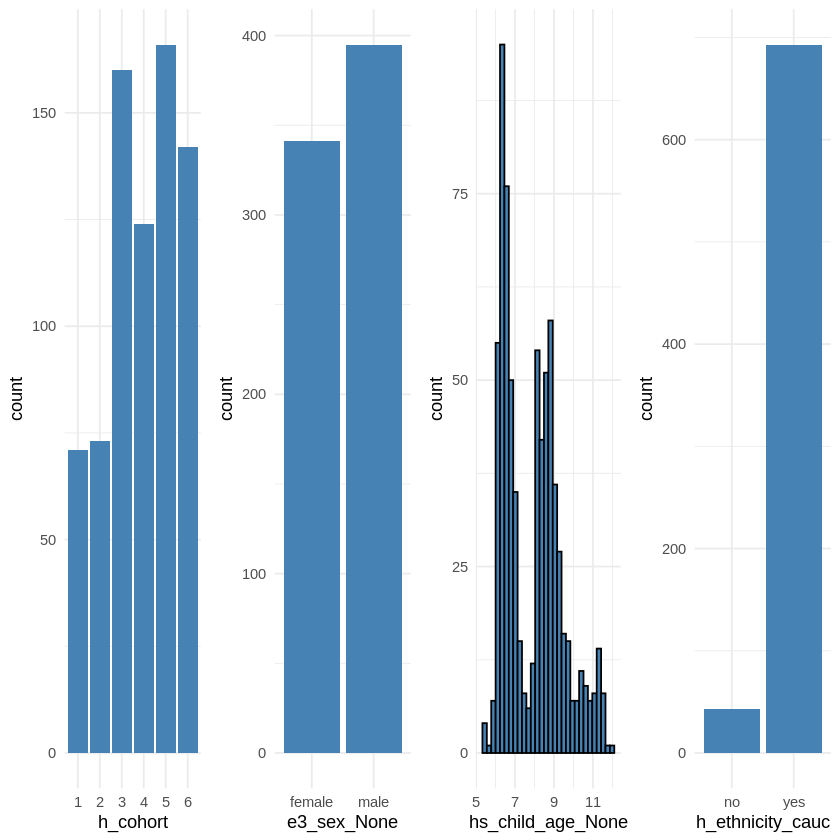

In [46]:
#covariates
p1 <- ggplot(covariatesNA, aes(x = h_cohort)) +
  geom_bar(fill = "steelblue") +
  theme_minimal()

p2 <- ggplot(covariatesNA, aes(x = e3_sex_None)) +
  geom_bar(fill = "steelblue") +
  theme_minimal()

p3 <- ggplot(covariatesNA, aes(x = hs_child_age_None)) +
  geom_histogram(fill = "steelblue", bins = 30, color = "black") +
  theme_minimal()

p4 <- ggplot(pData(proteome), aes(x = h_ethnicity_cauc)) +
  geom_bar(fill = "steelblue") +
  theme_minimal()

# Arrange the three plots in one composite figure
grid.arrange(p1, p2, p3, p4, ncol = 4)

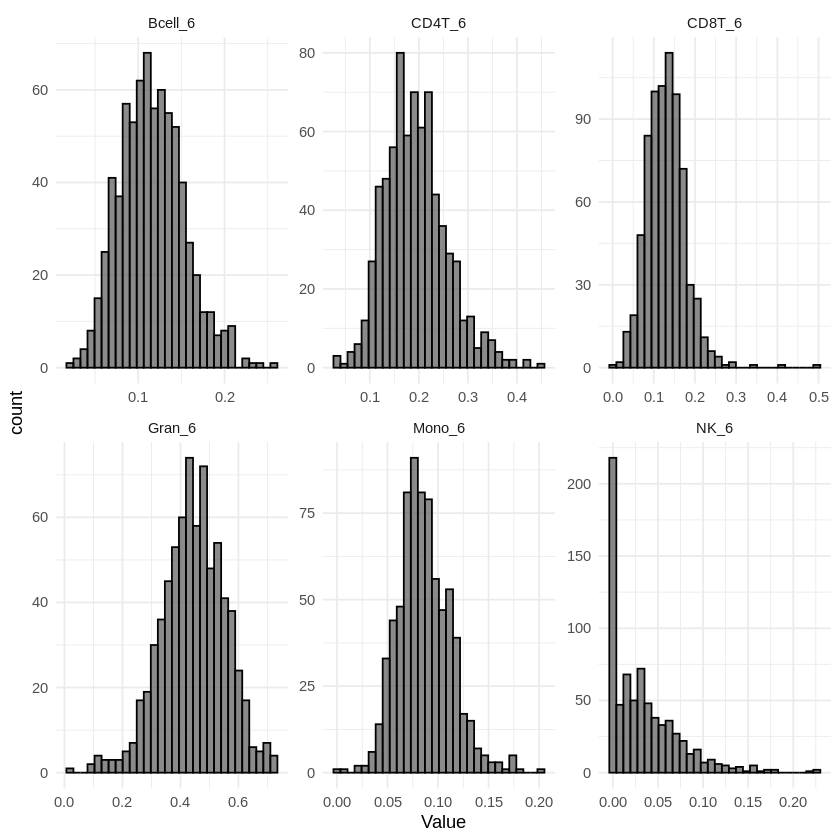

In [47]:
immune_cells<- c("NK_6", "Bcell_6", "CD4T_6", "CD8T_6", "Gran_6", "Mono_6")

pData(methy) %>%
  as_tibble(rownames = "SampleID") %>%
  pivot_longer(cols = all_of(immune_cells), names_to = "CellType", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  geom_histogram(bins = 30, color = "black", alpha = 0.7) +
  facet_wrap(~CellType, scales = "free") +
  theme_minimal()

In [48]:
#bmi_cat
phenotypeNA$hs_bmi_c_cat <- factor(phenotypeNA$hs_bmi_c_cat,
                                   levels = 1:4,
                                   labels = c("Underweight", "Normal weight", "Overweight", "Obese"))
bmi_table <- as.data.frame(table(phenotypeNA$hs_bmi_c_cat))
bmi_table$Percent <- round(100 * bmi_table$Freq / sum(bmi_table$Freq), 1)
colnames(bmi_table) <- c("BMI Category", "Count", "Percent (%)")

knitr::kable(bmi_table, caption = "Distribution of BMI Categories")



Table: Distribution of BMI Categories

|BMI Category  | Count| Percent (%)|
|:-------------|-----:|-----------:|
|Underweight   |     8|         1.1|
|Normal weight |   508|        69.0|
|Overweight    |   141|        19.2|
|Obese         |    79|        10.7|

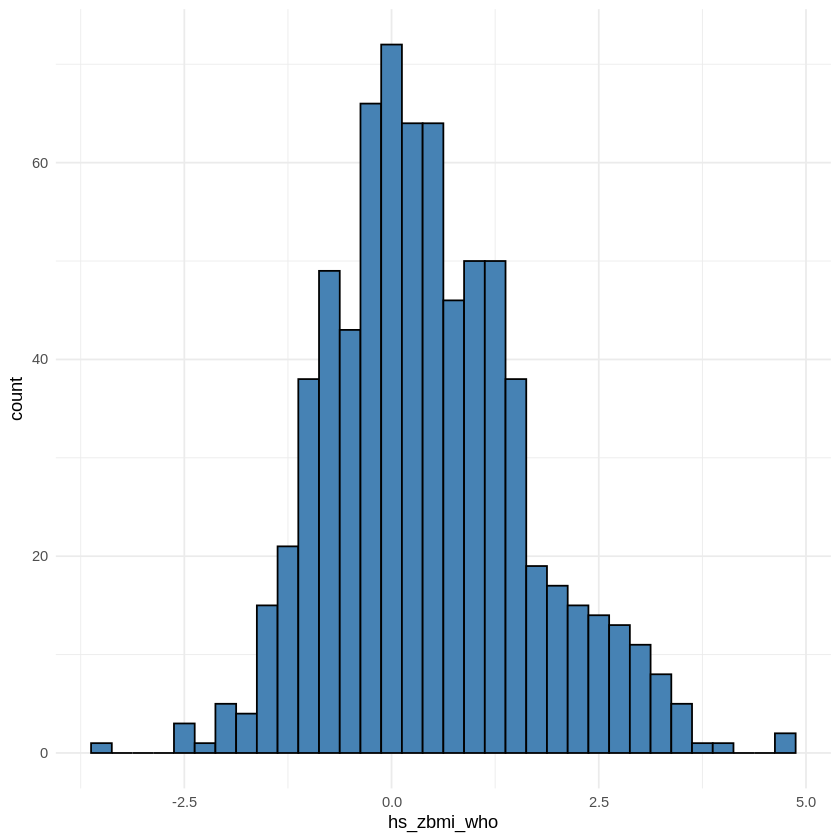

In [49]:
#bmi
ggplot(phenotypeNA, aes(x = hs_zbmi_who)) +
  geom_histogram(binwidth = 0.25, fill = "steelblue", color = "black") +
  theme_minimal()

**1. Winsorization**

In [50]:
#Winsorization function
process_outliers <- function(ms, offset = 0.001) {

  # Extract data based on object class
  if (inherits(ms, "ExpressionSet")) {
    bs <- exprs(ms)
  } else if (inherits(ms, "GenomicRatioSet")) {
    bs <- getBeta(ms)
  } else {
    stop("Input must be either ExpressionSet or GenomicRatioSet")
  }

  # Apply Winsorization column-wise
  bs <- apply(bs, 2, function(x) Winsorize(x))

  return(bs)
}

exprs(proteome) <- process_outliers(proteome)
assay(methy, "Beta") <- process_outliers(methy)
exprs(genexpr) <- process_outliers(genexpr)

**2. Denoising**

We will denoise each omic layer for sex, age, cohort, ethnicity. Additionally we will denoise methylation data for immune cell values as tecnical covariate. To include factors in denoising or statistical models, they must be converted into dummy variables—numeric 0/1 indicators that represent each category.


In [51]:
# Prepare covariate df
covariatesNA <- dummy_cols(covariatesNA,
                           select_columns = "h_cohort",
                           remove_selected_columns = TRUE,
                           remove_first_dummy = TRUE)

rownames(covariatesNA) <- covariatesNA$ID
covariates_df <- covariatesNA[c("e3_sex_None", "hs_child_age_None","h_cohort_2", "h_cohort_3", "h_cohort_4", "h_cohort_5", "h_cohort_6")]

all(rownames(pData(methy))==rownames(covariates_df))
covariates_df <- cbind(covariates_df, pData(methy)[,c(immune_cells, "h_ethnicity_cauc")])
covariates_df$h_ethnicity_cauc <- as.factor(covariates_df$h_ethnicity_cauc)

[1] TRUE

In [52]:
# Denoising functions
denoise_omics <- function(omics_matrix, covariate_data, covariates= c("e3_sex_None", "hs_child_age_None","h_cohort_2", "h_cohort_3", "h_cohort_4", "h_cohort_5", "h_cohort_6", "h_ethnicity_cauc")) {
  # Arguments:
  # omics_matrix: rows = features (genes/proteins/metabolites), columns = samples
  # covariate_data: data.frame with covariates (rows = samples)
  #covariates: vector of covariates

  # Check sample names
  if (!all(colnames(omics_matrix) == rownames(covariate_data))) {
    stop("Sample names in omics matrix and covariate data must match!")
  }

  covariate_data1 <- covariate_data[covariates]
  # Create model matrix for covariates
  covariate_model <- model.matrix(~ ., data = covariate_data1)

  # Fit linear model using limma
  fit <- lmFit(omics_matrix, covariate_model)

  # Extract residuals = denoised data
  denoised_matrix <- residuals(fit, omics_matrix)

  return(denoised_matrix)
  }

# denoise
exprs(proteome) <- denoise_omics(exprs(proteome), covariates_df)
assay(methy, "Beta") <- denoise_omics(getBeta(methy), covariates_df,
                                      c("e3_sex_None", "hs_child_age_None","h_cohort_2", "h_cohort_3", "h_cohort_4",
                                        "h_cohort_5", "h_cohort_6", "h_ethnicity_cauc", immune_cells))
exprs(genexpr) <- denoise_omics(exprs(genexpr), covariates_df)

**3. Normalization**

The next step would typically be cross-omic normalization, but RGCCA already handles this internally.

## **4. Multi-omics integration**

We will use RGCCA [(Tenenhaus et al., 2017)](10.1007/s11336-017-9573-x) to integrate the different omic layers. This is a multivariate method that integrates multiple omics layers by identifying components that capture shared variation across them, maximizing the correlation between components from different data blocks.

We will divide the population into training (70 %) and testing (30%) sets. This separation allows us to train models on one subset of the data (the training set) and then evaluate their performance on an independent subset (the testing set). By doing so, we can assess how well the model generalizes to new, unseen data and avoid overfitting.


In [53]:
set.seed(123)
x <- sample(1:length(common_ids), size = 0.7 * length(common_ids))
train_ids <- common_ids[x]
test_ids <- common_ids[-x]

#Prepare df
X_train <- list("Prot" = t(exprs(proteome))[rownames(t(exprs(proteome))) %in% train_ids, ],
                "Methyl" = t(getBeta(methy))[rownames(t(getBeta(methy))) %in% train_ids, ],
                "Genexpr" = t(exprs(genexpr))[rownames(t(exprs(genexpr))) %in% train_ids, ],
                "Y" = phenotypeNA[phenotypeNA$ID %in% train_ids, "hs_zbmi_who", drop = F])


X_test <- list("Prot" = t(exprs(proteome))[rownames(t(exprs(proteome))) %in% test_ids, ],
                "Methyl" = t(getBeta(methy))[rownames(t(getBeta(methy))) %in% test_ids, ],
                "Genexpr" = t(exprs(genexpr))[rownames(t(exprs(genexpr))) %in% test_ids, ],
                "Y" = phenotypeNA[phenotypeNA$ID %in% test_ids, "hs_zbmi_who", drop = F])


X_pooled <- list("Prot" = rbind(X_train$Prot, X_test$Prot),
                 "Methyl" = rbind(X_train$Methyl, X_test$Methyl),
                 "Genexpr" = rbind(X_train$Genexpr, X_test$Genexpr),
                 "Y" = rbind(X_train$Y,X_test$Y))

As a first step, we tuned the algorithm’s hyperparameters (sparsity and number of components) using cross-validation. The optimal hyperparameter configuration was determined by minimizing the root mean squared error (RMSE):

* Sparsity controls the number of variables contributing to each component, with higher sparsity selecting fewer variables.

* Number of components (ncomp) specifies how many latent variables are extracted per block to capture the main sources of shared variation across datasets.

The connection matrix specifies which data blocks are connected and allowed to share information, defining the relationships modeled between datasets during multiblock analysis (1 indicates that the two blocks are connected; 0 indicates that the two blocks are not connected).

**Example:** Imagine we have transcriptomics, methylation, and metabolomics data. Based on prior knowledge, we want our algorithm not to maximize the correlation between metabolomics and transcriptomics.


In [54]:
C <- matrix(c(0, 1, 0,
              1, 0, 1,
              0, 1, 0),  nrow = 3, byrow = TRUE)
rownames(C) <- colnames(C) <- c("transcriptomics", "methylation", "metabolomics")
print(C)

                transcriptomics methylation metabolomics
transcriptomics               0           1            0
methylation                   1           0            1
metabolomics                  0           1            0


In [55]:
#Sparsity tuning
min.sparsity <- 1 / sqrt(sapply(X_train, ncol))
sparsity_grid <- expand.grid("Prot" = seq(0.6,1, length.out=3),
                              "Methyl"= seq(0.1,0.3, length.out=3),
                              "Genexpr"= seq(0.1,0.3, length.out=3),
                              "Y"= seq(min.sparsity[4],1, length.out=3))
#Ideally we would like to test more sparsity values, but we're only trying 3 because if not would take too long


In [56]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13926062,743.8,27371307,1461.8,27371307,1461.8
Vcells,31004667,236.6,610774649,4659.9,660008763,5035.5


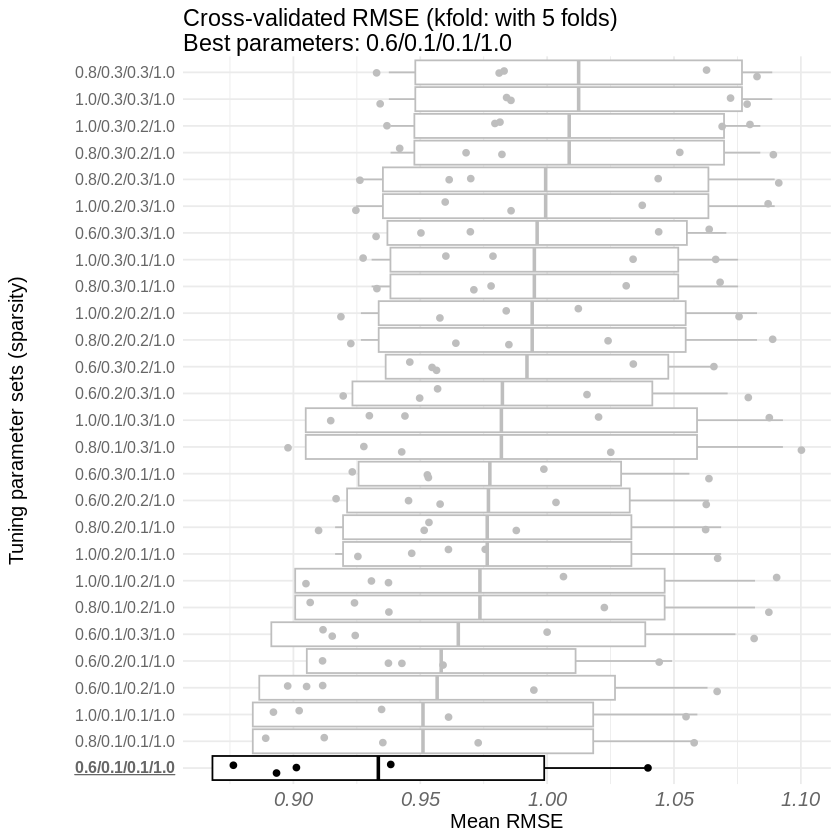

In [57]:
C <- 1 - diag(length(X_train))
# fully connected, 0s on diagonal, 1s elsewhere #We create connection matrix, in our case we will maximize correlation between all omics
set.seed(1234)
# Sparsity tuning (1min)
cv_sgcca_sparsity <- rgcca_cv(blocks=X_train,
                              connection = 1 - diag(4),
                              response= 4,
                              method="sgcca",
                              par_value= sparsity_grid,
                              ncomp=1,
                              par_type="sparsity",
                              n_cores= detectCores())

plot(cv_sgcca_sparsity)

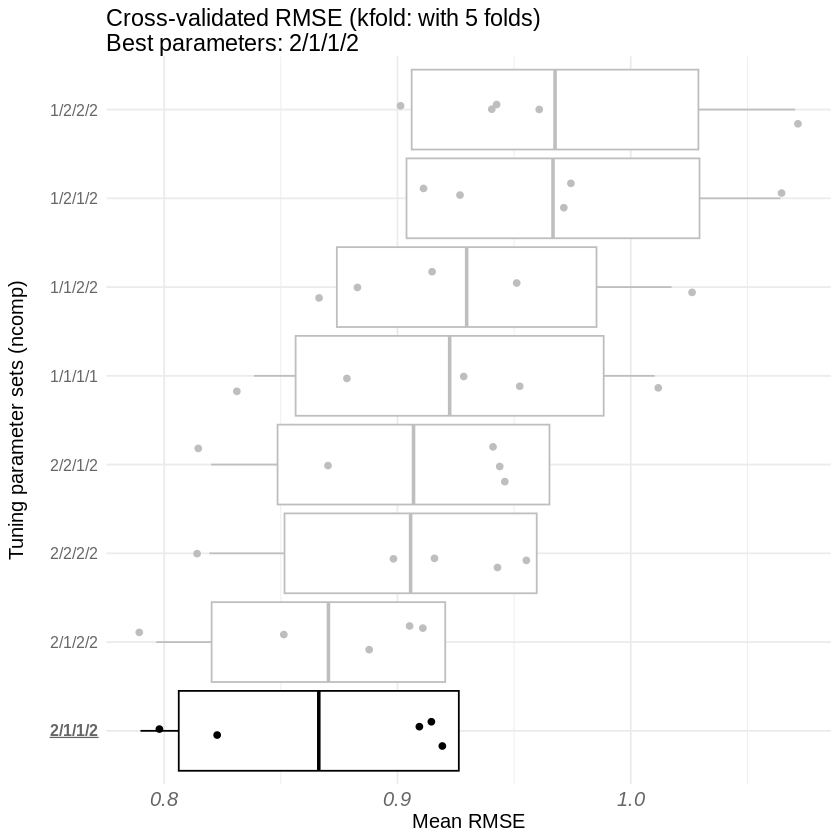

In [58]:
#Number of components tuning (estimated time 30s)
cv_sgcca_ncomp  <- rgcca_cv(blocks = X_train,
                            response = 4,
                            method = "sgcca",
                            par_type = "ncomp",
                            sparsity =  cv_sgcca_sparsity$best_params,
                            par_value = expand.grid("Prot" = 1:2,  "Methyl"= 1:2, "Genexpr"=1:2, "Y"=1),
                            n_cores = detectCores(),
                            connection =  1 - diag(4))

plot(cv_sgcca_ncomp)

In [59]:
#run the model
rgcca_res <- rgcca(cv_sgcca_ncomp, ncomp = cv_sgcca_ncomp$best_params)
bootstrap <- rgcca_bootstrap(rgcca_res,n_boot = 100, n_cores = detectCores())
rgcca_res <- bootstrap$rgcca
summary(rgcca_res)

Only selected variables were used for bootstrapping. see rgcca_stability().

Bootstrap samples sanity check...
OK



Call: method='sgcca', superblock=FALSE, scale=TRUE, scale_block=TRUE, init='svd',
bias=TRUE, tol=1e-08, NA_method='na.ignore', ncomp=c(2,1,1,2), response=4,
comp_orth=TRUE 
There are J = 4 blocks.
The design matrix is:
        Prot Methyl Genexpr Y
Prot       0      1       1 1
Methyl     1      0       1 1
Genexpr    1      1       0 1
Y          1      1       1 0

The factorial scheme is used.
Sum_{j,k} c_jk g(cov(X_j a_j, X_k a_k) = 0.2494 

The sparsity parameter used for Prot is: 1 (with 34, 34 variables selected)
The sparsity parameter used for Methyl is: 1 (with 15 variables selected)
The sparsity parameter used for Genexpr is: 1 (with 3 variables selected)
The sparsity parameter used for Y is: 1 (with 1, 1 variables selected)



To evaluate the performance of the algorithm we will use three metrics:
* **RMSE** (Root Mean Square Error): Measures the average magnitude of prediction errors, giving higher weight to large errors — lower values mean better accuracy.
* **R2** (Rsquared): Indicates how well the model explains the variance in the target variable — values closer to 1 mean a better fit.
* **MAE** (Mean Absolut Error): Measures the average absolute difference between predicted and actual values — lower values mean more accurate predictions.

In [60]:
#We can estimate model performance with rgcca_predict in the test population
#colnames(X_test$Prot) <- paste0("Prot_", colnames(X_test$Prot))
#colnames(X_test$Methyl) <- paste0("Methyl_", colnames(X_test$Methyl))
#colnames(X_test$Genexpr) <- paste0("Genexpr_", colnames(X_test$Genexpr))
#colnames(X_test$Y) <- paste0("Y_", colnames(X_test$Y))

rgcca_predict_res <- rgcca_predict(rgcca_res,blocks_test=X_test,prediction_model="lm")
rgcca_predict_res$metric

,hs_zbmi_who
,<dbl>
RMSE,0.8177658
Rsquared,0.5280540
MAE,0.6571624
,hs_zbmi_who
,<dbl>
RMSE,0.9083674
Rsquared,0.3977177
MAE,0.7176477


We will calculate cross-validated (5-fold) R2 in test population to assess how well the biomarkers predict each omic-specific latent component (LC).

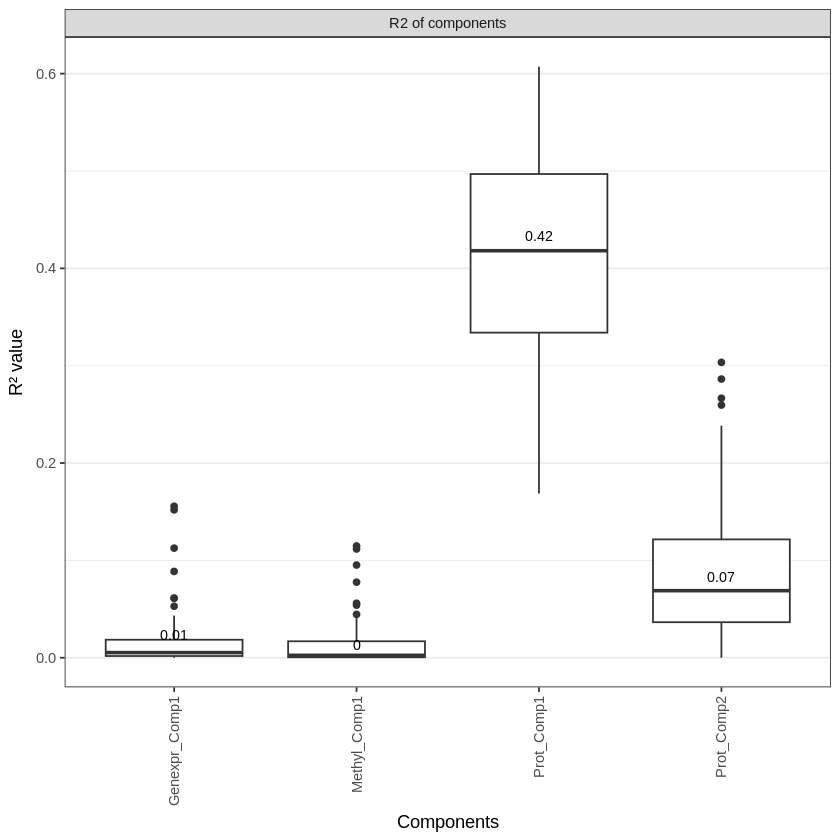

In [61]:
# R2 CV
source("https://raw.githubusercontent.com/adriasell/Multi-omics-integration-Tutorial/main/Functions/functions.R")
r2_res <- cross_validation_single_outcome(X_test = X_test, response = 4, rgcca_res = rgcca_res)

res_long_r2 <- r2_res$quality_all %>%
  filter(grepl("^R2_", Indicator))

medians_r2 <- res_long_r2 %>%
  group_by(Indicator, group) %>%
  summarise(md = round(median(value, na.rm = TRUE), 2), .groups = "drop")

comp_names <- paste0(rep(names(rgcca_res$blocks)[-4], times = rgcca_res$call$ncomp[-4]), "_Comp", unlist(lapply(rgcca_res$call$ncomp[-4], seq)))

#Change comp names
res_long_r2$Indicator <- rep(comp_names, 50)
medians_r2$Indicator <- comp_names

# Plot
ggplot(res_long_r2, aes(x = Indicator, y = value)) +
  geom_boxplot() +
  ggforce::facet_row(vars(group), scales = 'free', space = 'free') +
  ggrepel::geom_text_repel(
    data = medians_r2,
    aes(x = Indicator, y = md, label = md),
    direction = "y",
    size = 3
  ) +
  xlab("Components") +
  ylab("R² value") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    panel.grid.major.x = element_blank())

We can extract the projections of each individual for each omic-specific latent component (LC) obtained from the RGCCA model. Each LC summarizes the main sources of variation within its corresponding omic while also capturing the shared structure and relationships with the other omics. This approach effectively reduces the dimensionality of each dataset while preserving inter-omic correlations. The resulting LCs can then be used, for example, to explore their associations with the outcome of interest or to identify exposures related to these components, potentially revealing underlying biological pathways.


In [62]:
#colnames(X_pooled$Prot) <- paste0("Prot_", colnames(X_pooled$Prot))
#colnames(X_pooled$Methyl) <- paste0("Methyl_", colnames(X_pooled$Methyl))
#colnames(X_pooled$Genexpr) <- paste0("Genexpr_", colnames(X_pooled$Genexpr))
#colnames(X_pooled$Y) <- paste0("Y_", colnames(X_pooled$Y))
rgcca_predict_all <- rgcca_predict(rgcca_res, blocks_test=X_pooled, prediction_model="lm")
latent_variables <- rgcca_predict_all$projection %>% purrr::reduce(cbind)%>% as.data.frame()
latent_variables <- latent_variables[phenotypeNA$ID,]

colnames(latent_variables) <- c(paste0(rep(names(rgcca_res$blocks)[-4],times = rgcca_res$call$ncomp[-4])))
colnames(latent_variables) <- paste0(colnames(latent_variables),unlist(lapply(rgcca_res$call$ncomp[-4],seq)))
cor(latent_variables) %>% round(2)

,Prot1,Prot2,Methyl1,Genexpr1
Prot1,1.00,0.04,0.24,-0.20
Prot2,0.04,1.00,0.06,-0.12
Methyl1,0.24,0.06,1.00,-0.07
Genexpr1,-0.20,-0.12,-0.07,1.00


Here, we can identify the estimated effects of the main biomarkers on each identified LC, along with their 95% confidence intervals obtained via bootstrapping.

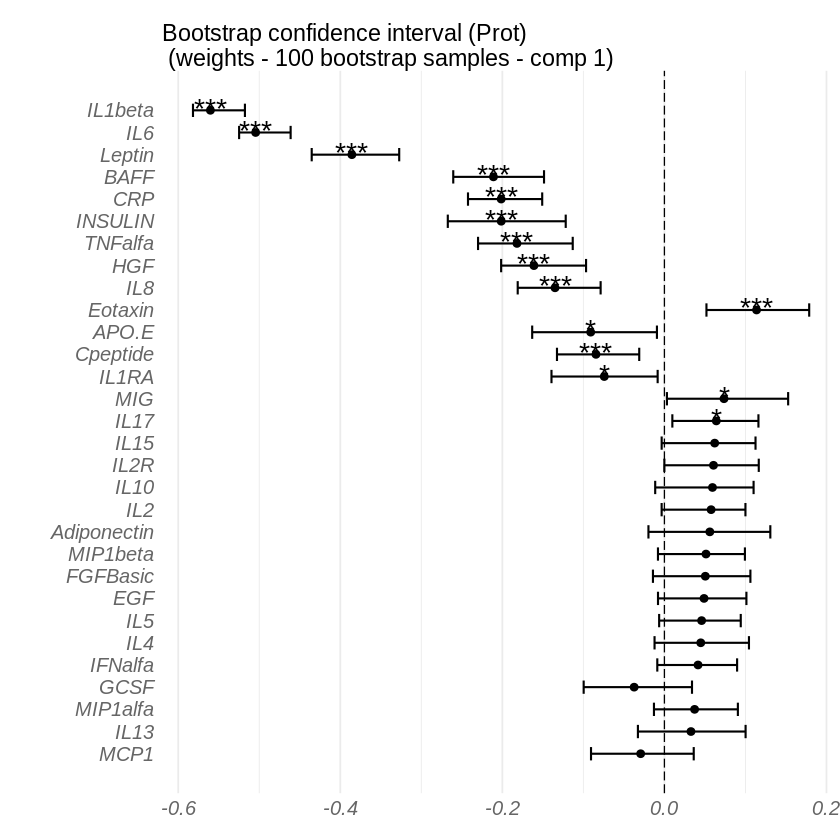

In [63]:
#Let's estimate the contributon of each biomarker and plot it
plot(bootstrap, comp = 1, block = 1)

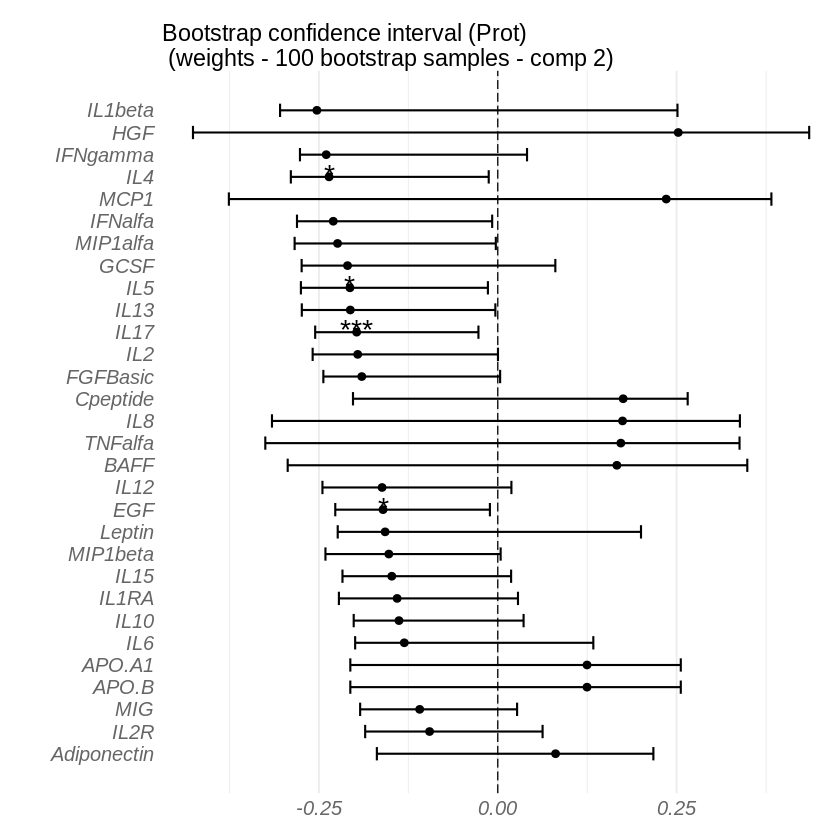

In [64]:
plot(bootstrap, comp = 2, block = 1)

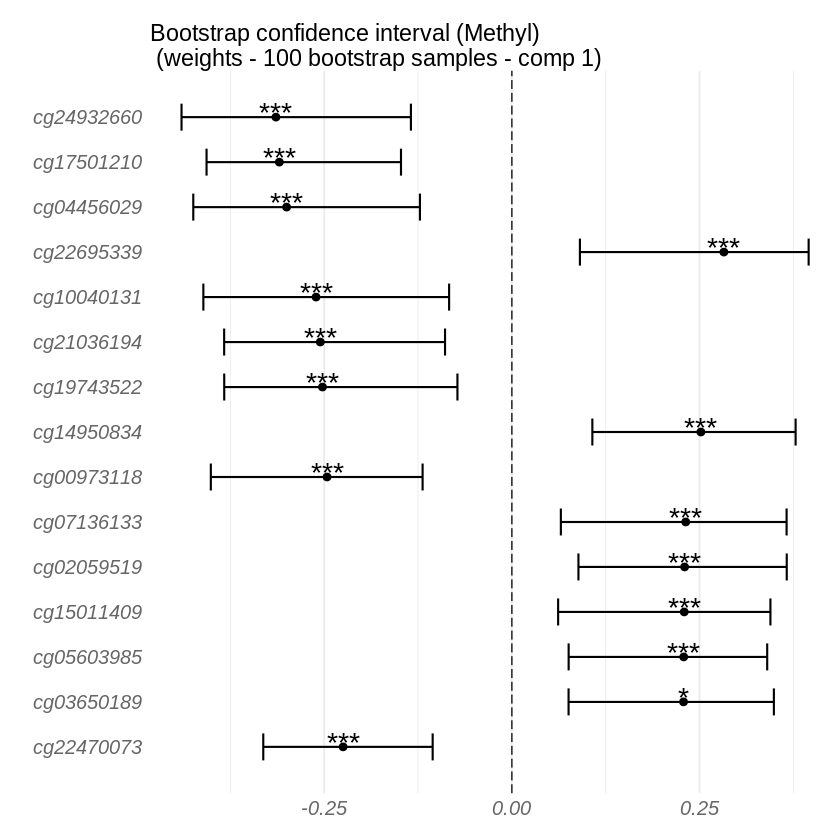

In [65]:
plot(bootstrap, comp = 1, block = 2)

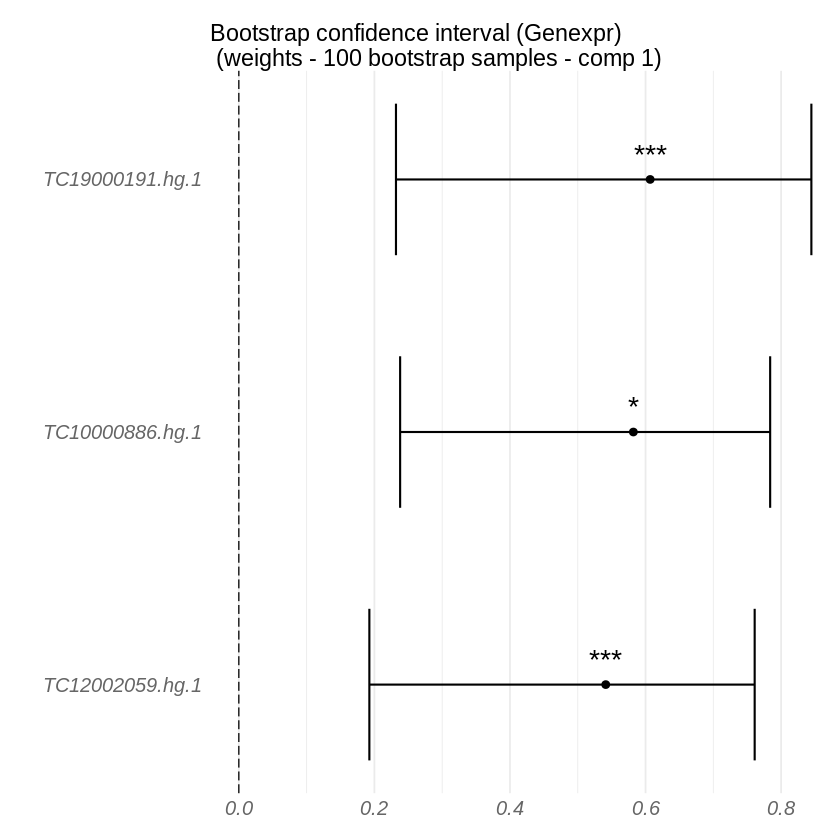

In [66]:
plot(bootstrap, comp = 1, block = 3)


A Sankey diagram is a flow chart in which the widths of the links represent the strength of the relationship between lipid clusters (LCs) and BMI, while the colors indicate the direction of the effect: red for LCs that increase BMI and green for LCs that decrease BMI.

To construct this diagram, we first perform a linear regression for each omics signature against the outcome.

In [67]:
#linear regression
results <- data.frame(
  variable = colnames(latent_variables),
  estimate = NA,
  std_error = NA,
  t_value = NA,
  p_value = NA)

# Loop through each column in latent_variables
for (i in seq_along(latent_variables)) {

  comp <- colnames(latent_variables)[i]
  # Build formula dynamically
  formula <- as.formula(paste("hs_zbmi_who ~ ", comp))
  # Run linear regression
  fit <- lm(formula, data = cbind(phenotypeNA, latent_variables))
  # Extract coefficients
  coef_summary <- summary(fit)$coefficients
  # Store estimate, std error, t-value, and p-value of the predictor
  results$estimate[i] <- coef_summary[comp, "Estimate"]
  results$std_error[i] <- coef_summary[comp, "Std. Error"]
  results$t_value[i] <- coef_summary[comp, "t value"]
  results$p_value[i] <- coef_summary[comp, "Pr(>|t|)"]}

  #Adjust p-value
results$p_value_adj <- p.adjust(results$p_value, method = "BH")

In [68]:
# Create links and nodes
results <- results %>% mutate(Outcome = "zBMI")

links <- data.frame(
  source = results$variable,
  target = results$Outcome,
  value = abs(results$estimate),
  sign  = ifelse(results$estimate > 0, "Positive", "Negative"))

nodes <- data.frame(name = unique(c(links$source, links$target)))
links$IDsource <- match(links$source, nodes$name) - 1
links$IDtarget <- match(links$target, nodes$name) - 1

# Define link colors
links$color <- ifelse(links$sign == "Positive", "red", "green")

# Sankey plot
p <- sankeyNetwork(
  Links = links,
  Nodes = nodes,
  Source = "IDsource",
  Target = "IDtarget",
  Value = "value",
  NodeID = "name",
  LinkGroup = "sign",
  colourScale = JS("d3.scaleOrdinal().domain(['Positive','Negative']).range(['red','green'])"),
  fontSize = 13,
  nodeWidth = 30)

# Force all nodes to grey using JavaScript after rendering
p <- htmlwidgets::onRender(p, "
  function(el, x) {
    d3.select(el).selectAll('.node rect')
      .style('fill', 'grey')
      .style('stroke', 'grey');
  }")

saveWidget(p, "sankey.html", selfcontained = TRUE)

Click the Files (icon folder) on the left-hand menu and download sankey.html to view the plot.

In [81]:
results

variable,estimate,std_error,t_value,p_value,p_value_adj,Outcome
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Prot1,-2.3991458,0.10367621,-23.140756,2.155299e-89,8.621197e-89,zBMI
Prot2,-0.6823302,0.10691733,-6.381849,3.098845e-10,4.131793e-10,zBMI
Methyl1,-1.3637742,0.14164143,-9.628356,9.599836e-21,1.919967e-20,zBMI
Genexpr1,0.3392264,0.07343488,4.619417,4.544137e-06,4.544137e-06,zBMI



# 5. Functional enrichment analysis

### Methylation
Once we have obtained a list with the CpGs that are significant in our analysis, we need to locate them in the genome and try to know which structures surround them. The annotation consists in obtaining this information:

First we load the annotation from IlluminaHumanMethylation450kanno.ilmn12.hg19 R package and select the columns of interest:

In [69]:
methy@annotation

array                     annotation 
"IlluminaHumanMethylation450k"                  "ilmn12.hg19"

In [70]:
data("IlluminaHumanMethylation450kanno.ilmn12.hg19")
annotation.table<- getAnnotation("IlluminaHumanMethylation450kanno.ilmn12.hg19")
annotation.table<-as.data.frame(annotation.table[,c("chr","pos","strand",
                                                    "Name","Islands_Name",
                                                    "Relation_to_Island",
                                                    "UCSC_RefGene_Name",
                                                    "UCSC_RefGene_Group")])
cpg_anno <- annotation.table[rownames(annotation.table) %in% rownames(rgcca_res$a$Met),]

ann.genes.current <- cpg_anno$UCSC_RefGene_Name
ann.genes.current <- unlist(lapply(strsplit(ann.genes.current, ";"), unique))

ids <- bitr(ann.genes.current, fromType="SYMBOL", toType=c("ENSEMBL", "ENTREZID"), OrgDb="org.Hs.eg.db")
cpg_anno[c("UCSC_RefGene_Name")]

'select()' returned 1:1 mapping between keys and columns



,UCSC_RefGene_Name
,<chr>
cg24932660,CD164L2
cg22470073,HELQ;MRPS18C;HELQ
cg04456029,DTX1
cg19743522,DTX1
cg14950834,SPTBN4;BLVRB
cg05603985,SKI
cg10040131,SFXN5
cg21036194,SNCAIP
cg17501210,RPS6KA2;RPS6KA2


In [71]:
data(org.Hs.egGO)
df = as.data.frame(org.Hs.egGO)
go_gene_list = unique(sort(df$gene_id))
ans.go <- enrichGO(gene = ids$ENTREZID,
                   ont = "ALL",
                   OrgDb ="org.Hs.eg.db",
                   universe = go_gene_list,
                   readable=TRUE,
                   pvalueCutoff = 0.05)

tab.go <- as.data.frame(ans.go)
tab.go<- subset(tab.go, Count>1)
tab.go[c(1,3,12,13)]

Warning message in data(org.Hs.egGO):
“data set ‘org.Hs.egGO’ not found”


,ONTOLOGY,Description,geneID,Count
,<chr>,<chr>,<chr>,<int>
GO:0016605,CC,PML body,SPTBN4/SKI/CHD3,3
GO:0031625,MF,ubiquitin protein ligase binding,DTX1/SKI/SNCAIP/PRR5L/AXIN1,5
GO:0044389,MF,ubiquitin-like protein ligase binding,DTX1/SKI/SNCAIP/PRR5L/AXIN1,5
GO:0061749,MF,forked DNA-dependent helicase activity,HELQ/CHD3,2
GO:1990518,MF,single-stranded 3'-5' DNA helicase activity,HELQ/CHD3,2
GO:0009378,MF,four-way junction helicase activity,HELQ/CHD3,2
GO:0036121,MF,double-stranded DNA helicase activity,HELQ/CHD3,2
GO:0043138,MF,3'-5' DNA helicase activity,HELQ/CHD3,2
GO:0017116,MF,single-stranded DNA helicase activity,HELQ/CHD3,2


The idea is to compare the list of genes that overlap our CpGs with the list of all the human genes that are anotated in specific databases. With this, we can see if our list of genes is a random subset or no. First of all we convert Gene Symbols to Ensembl and Entrez Gene IDs to use them later

This plot shows which GO terms are enriched and their significance/gene count.


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


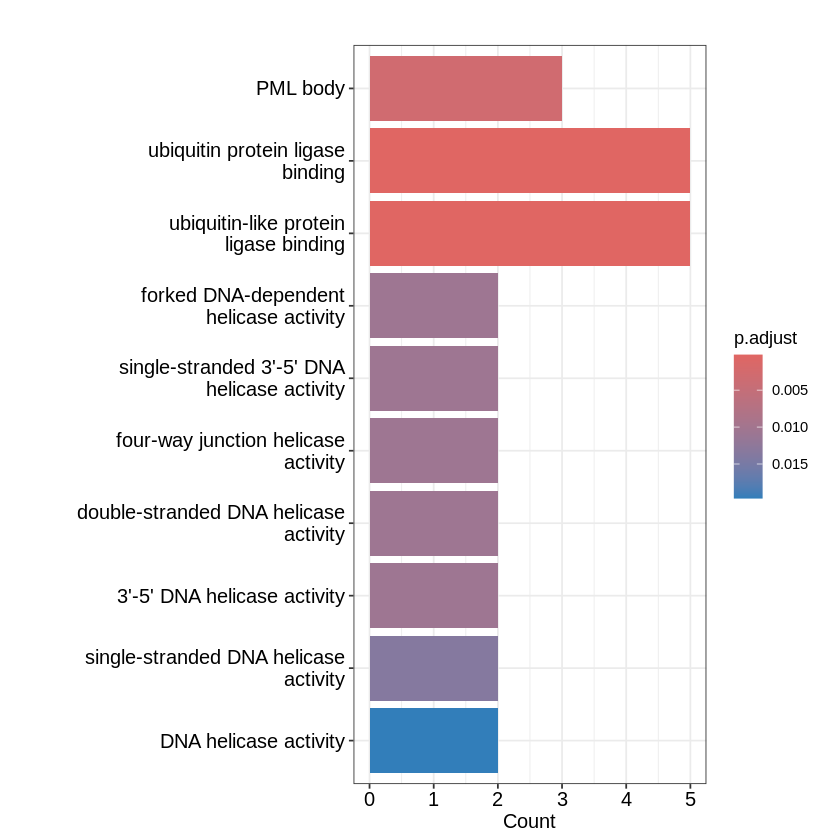

In [72]:
p1 <- barplot(ans.go, showCategory=10) +
  theme(plot.title = element_text(size = 18))

p1

This plot show GO terms relate to each other; clusters of similar biological processes.


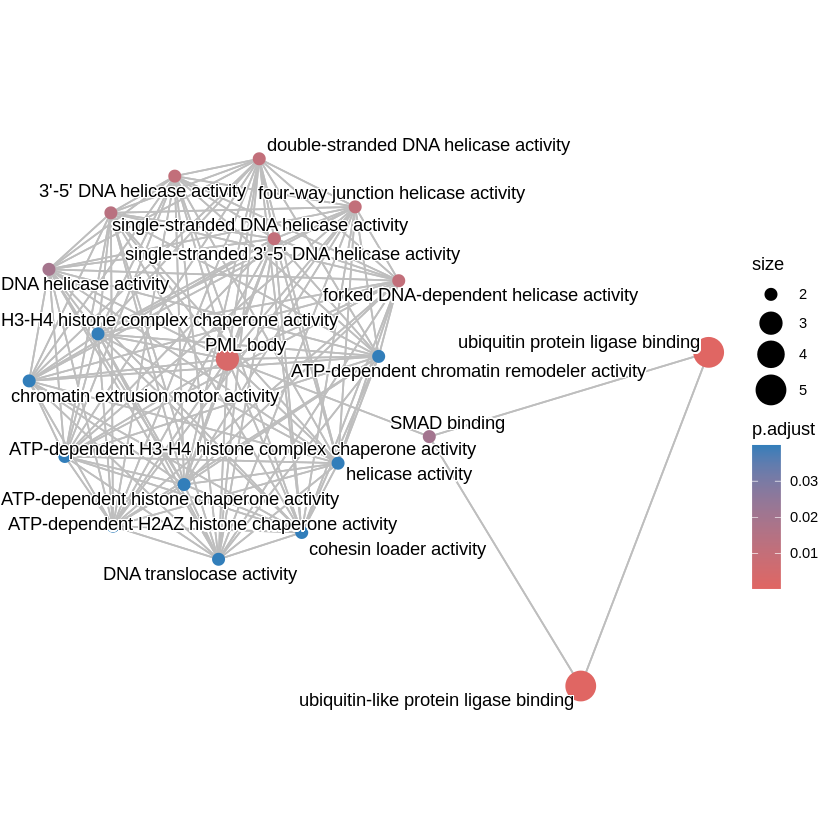

In [76]:
ans.go <- pairwise_termsim(ans.go)
p2 <- emapplot(ans.go, showCategory = 20) +
  theme(plot.title = element_text(size = 18))
p2

This plot shows which genes contribute to enrichment; visualizing the gene-GOterm network.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggtangle package.
  Please report the issue to the authors.”


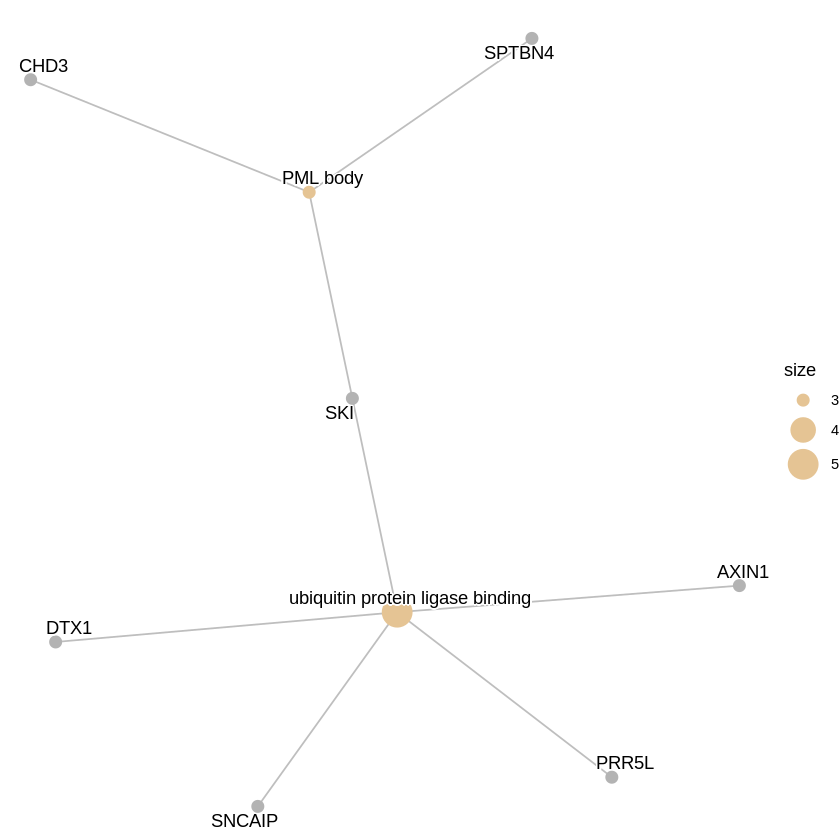

In [75]:
p3 <- cnetplot(ans.go, circular = FALSE, colorEdge = TRUE, showCategory = 2)
p3

### Gene expression


In [77]:
transcripts <- rownames(rgcca_res$a$Genexpr)
genexpr_df <- genexpr@featureData@data[genexpr@featureData@data$transcript_cluster_id %in% transcripts,]
ann.genes.current <- genexpr_df$GeneSymbolDB
ann.genes.current <- unlist(lapply(strsplit(ann.genes.current, ";"), unique))
ids <- bitr(ann.genes.current, fromType="SYMBOL", toType=c("ENSEMBL", "ENTREZID"), OrgDb="org.Hs.eg.db")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ann.genes.current, fromType = "SYMBOL", toType = c("ENSEMBL", :
“25% of input gene IDs are fail to map...”


In [78]:
data(org.Hs.egGO)
df = as.data.frame(org.Hs.egGO)
go_gene_list = unique(sort(df$gene_id))
ans.go <- enrichGO(gene = ids$ENTREZID,
                   ont = "ALL",
                   OrgDb ="org.Hs.eg.db",
                   universe = go_gene_list,
                   readable=TRUE,
                   pvalueCutoff = 0.05)

tab.go <- as.data.frame(ans.go)
tab.go<- subset(tab.go, Count>1)
tab.go[c(1,3,12,13)]

Warning message in data(org.Hs.egGO):
“data set ‘org.Hs.egGO’ not found”


,ONTOLOGY,Description,geneID,Count
,<chr>,<chr>,<chr>,<int>
GO:0019058,BP,viral life cycle,OASL/LDLR,2
GO:0008202,BP,steroid metabolic process,PLEKHA1/LDLR,2
GO:0016032,BP,viral process,OASL/LDLR,2


This plot shows Which GO terms are enriched and their significance/gene count.


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


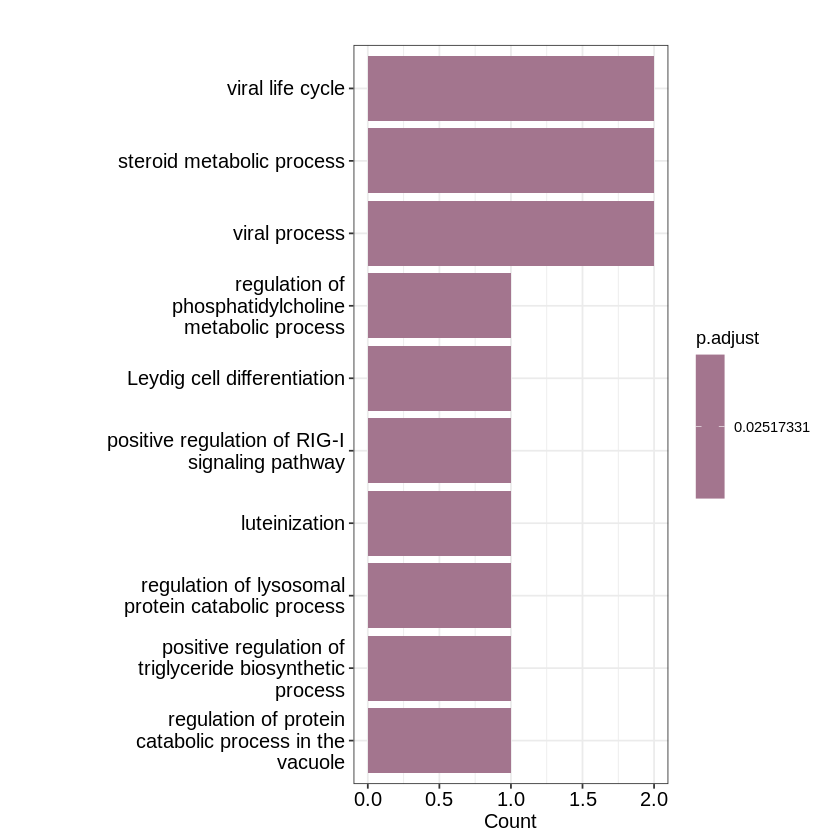

In [79]:
p1 <- barplot(ans.go, showCategory=10) +
  theme(plot.title = element_text(size = 18))

p1

This plot show GO terms relate to each other; clusters of similar biological processes.


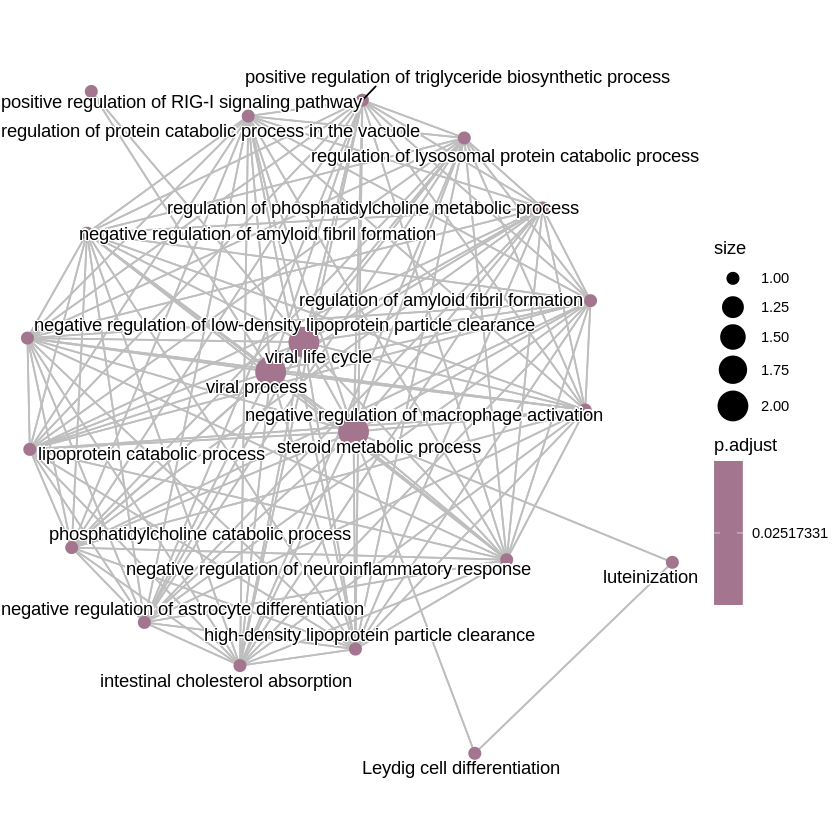

In [82]:
ans.go <- pairwise_termsim(ans.go)
p2 <- emapplot(ans.go, showCategory = 20) +
  theme(plot.title = element_text(size = 18))
p2

This plot shows which genes contribute to enrichment; visualizing the gene-GOterm network.

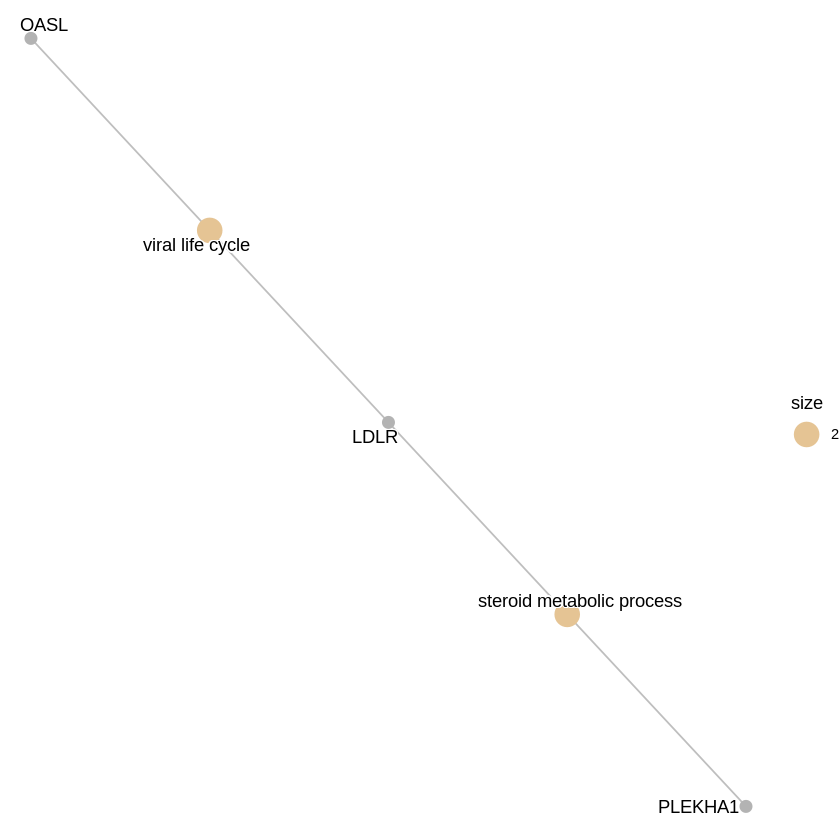

In [83]:
p3 <- cnetplot(ans.go, circular = FALSE, colorEdge = TRUE, showCategory = 2)
p3

## **6. Conclusions**

* Four distinct molecular signatures were identified: (1) low pro-inflammatory protein levels signature (Prot1-LC), (2) low pro-inflammatory signature (Prot2-LC), (3) Methyl-LC (4) Genexpr-LC.

* Prot1-LC, Prot2-LC, and Methyl-LC are inversely associated with BMI, while Genexpr-LC is positively associated with BMI.

* The protein components account for most of the explained variance, while methylation and gene expression components contribute only marginally. Nonetheless, within these latter layers, detectable associations may still point to biologically relevant underlying mechanisms.

* Enrichment analysis and functional annotation of BMI-associated molecular signatures reveal complementary insights. The methylation signature highlights the involvement of SKI, AXIN1, and DTX1 in regulating cellular signaling and protein degradation through interactions with nuclear bodies and ubiquitin-related proteins, pointing to key mechanisms of transcriptional control and TGF-β signaling pathways. Meanwhile, the gene expression signature implicates OASL, LDLR, and PLEKHA1 in viral-related processes, steroid metabolism, and activation of immune response signaling pathways, suggesting coordinated regulation of antiviral defense and metabolic processes linked to BMI.

